# Coupon Code Machine Learning

When a new `master_code` is released each month, I have a 2%-5% valid coupon rate after finding the first valid coupon of a given prefix.
A week after the `master_code` is released, this increases to a 5%-10% valid coupon rate.

### Objective:
Develop a machine learning model to predict valid coupon codes faster and more reliably, reducing downtime and ensuring the store can maintain 100% uptime by keeping a steady pool of valid coupons.
### Output:
 prediction model that identifies valid coupon codes, increasing the accuracy and speed of finding these codes to avoid interruptions in sales. The output will be a binary classification (valid or invalid) for each coupon tested.

### Current Workflow:
1. **Analyze Distances**: Generate a list of the most common distances between valid coupon codes over the past 3 months (e.g., `common_digits = [1, 5, 7, 55, 56, ..., 150, 151]`).
2. **Initial Testing**: Test the first 500 digits of a prefix until the first valid coupon is found.
3. **Generate Coupons**: Use the `common_digits` to generate 10 coupons based on the last valid code.
4. **Bot Testing**: Test the coupons; if no valid coupon is found, repeat step 3.
5. **Fallback**: If all common distances are exhausted, test the next 200 consecutive digits.
6. **Cycle**: Once another valid coupon is found, restart the process from step 3 using the most recent valid coupon.

### Updated Workflow with Machine Learning:
1. **Train Machine Learning Model**: Use past data (prefix, random digits, master code, distances, validity) to train a model that predicts the likelihood of a coupon being valid.
2. **Initial Testing**: Test the first 500 random digits of a prefix using the model's prediction probabilities to prioritize the most likely valid codes. If a valid coupon is found, proceed to the next step.
3. **Generate Predictions**: Instead of relying solely on `common_digits`, use the machine learning model to predict and generate the next 10 likely valid coupons based on the most recent valid coupon.
4. **Bot Testing**: Test the model-predicted coupons. If a valid coupon is found, continue with the process. If not, generate another batch of predictions.
5. **Fallback Strategy**: If predictions fail after multiple iterations, revert to testing the next 200 consecutive digits as a fallback.
6. **Iterate with Model**: Once another valid coupon is found, update the model with the new data to improve future predictions and restart the process from step 3.

# **Data Collection**

1. **Initialize Puppeteer Instance**: We start by launching a puppeteer instance that simulates a user browsing the website.

2. **Send REST Requests**: The puppeteer instance sends REST requests to a server running locally on the same machine.

3. **Automate Mouse Movements**: The REST server automates mouse movements outside the browser instance to mimic human interactions, helping to avoid anti-bot detection.

4. **Test Coupons on Cart Page**: Each coupon is tested on the cart page within the website.

5. **Receive XHR Response**: An XHR request is triggered, and we receive a response indicating whether the coupon is valid or invalid.

6. **Store Results**: The results of each coupon validation are captured and sent back to the REST server to be logged for further analysis
---

# **Data Preperation & Feature Engineering**

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_parquet('data/coupons.parquet') # limited dataset to 10000 records, demonstration is shown with 1,000,000 records

#### **Coupon Code Structure: `{prefix}{random_digits}{master_code}{checksum}`**

1) Extract the components of the coupon code into our dataframe
2) Discard coupon code column

In [131]:
df['prefix'] = df['code'].str[:5].astype(int)  # First 5 digits for prefix
df['random_digits'] = df['code'].str[5:10].astype(int)  # Next 5 digits for random digits
df['mastercode'] = df['code'].str[10:14].astype(int)  # Next 4 digits for mastercode
df['checksum'] = df['code'].str[14].astype(int)  # Last digit for checksum
df = df.drop(['code'], axis=1)  # no longer need the entire string

# Sort by mastercode (monthly), then by prefix within each mastercode, and finally by random_digits for each prefix+mastercode combination. Reset the index
df = df.sort_values(by=['mastercode', 'prefix', 'random_digits'], ascending=[True, True, True]).reset_index(drop=True)

#### **Drop groups that are too small to meaningfully contribute**

In [132]:
# Step 1: Group by 'mastercode' and 'prefix' to get the size of each group and valid counts
group_sizes = df.groupby(['mastercode', 'prefix']).size()
valid_counts = df[df['valid']].groupby(['mastercode', 'prefix']).size()  # Number of valid rows in each group

# Step 2: Filter groups that have at least 1000 rows and at least 20 valid codes
large_groups = group_sizes[(group_sizes >= 1000) & (valid_counts >= 20)].index

# Step 3: Filter the DataFrame to keep only rows from the large groups
df = df[df.set_index(['mastercode', 'prefix']).index.isin(large_groups)]

#### **Calculate new columns for distance to closest valid code**

In [133]:
# Group by 'prefix' and 'mastercode'
grouped = df.groupby(['prefix', 'mastercode'])

# Closest valid previous row (use ffill to propagate the last valid random_digits backward, then shift)
df['closest_valid_behind'] = grouped['random_digits'].transform(
    lambda group: group.where(df.loc[group.index, 'valid']).ffill().shift(1)
)

# Closest valid next row (use bfill to propagate the next valid random_digits forward, then shift)
df['closest_valid_front'] = grouped['random_digits'].transform(
    lambda group: group.where(df.loc[group.index, 'valid']).bfill().shift(-1)
)

# Calculate distances
df['distance_behind'] = df['random_digits'] - df['closest_valid_behind']
df['distance_front'] = df['closest_valid_front'] - df['random_digits']

# Clean up temporary columns and remove random_digits (captured by distances)
df = df.drop(['closest_valid_front', 'closest_valid_behind', 'random_digits'], axis=1)


#### **Missing Information**

Some valid rows lack `distance_behind` or `distance_front` due to no valid coupons within their group before or after them.

- I’ve identified large sections of "dead codes" where no valid coupons appear for over large spans of digits.
- I'm going to remove rows more than ~105 digits away from the last valid code, as these gaps may represent codes that were previously valid but were already used.
- I started with a higher number, but after plotting out the most common distances of valid codes I believe that most of the pattern is below 105


In [134]:
df = df.drop(df[df['distance_front'].isna() | df['distance_behind'].isna()].index)
# df = df.drop(df[df['distance_behind'].isna()].index)
df = df.drop(df[(df['distance_front'] > 105) | (df['distance_behind'] > 105)].index)
# df = df.drop(df[(df['distance_behind'] > 105)].index)
print(f'df shape= {df.shape}')

df shape= (517934, 6)



#### **Features so far**

- **`prefix`** (`int`, nominal): A 5-digit value ranging from 47000 to 49000 (order doesn't matter)
- **~~`random_digits`~~** (`str`, numeric): A 5-digit value (zero-filled) ranging from 00001 to 99999 (order matters).
- **`master_code`** (`int`, nominal): A 4-digit code that changes monthly (order doesn't matter).
- **`checksum`** (`int`, numeric): The checksum digit generated by the function `generate(prefix: str, random_digits: int, master_code: str) -> str`.
- **`forward_distance`** (`int`, numeric): The number of digits between this code’s random digits and the next valid code’s random digits.
- **`backward_distance`** (`int`, numeric): The number of digits between this code’s random digits and the previous valid code’s random digits.
- **`valid`** (`bool`, boolean): Indicates whether this coupon was found to be valid. (TARGET)
---


# **Exploratory Data Analysis**
#### Plotting percentage distribution of distance_behind

<Figure size 1200x600 with 0 Axes>

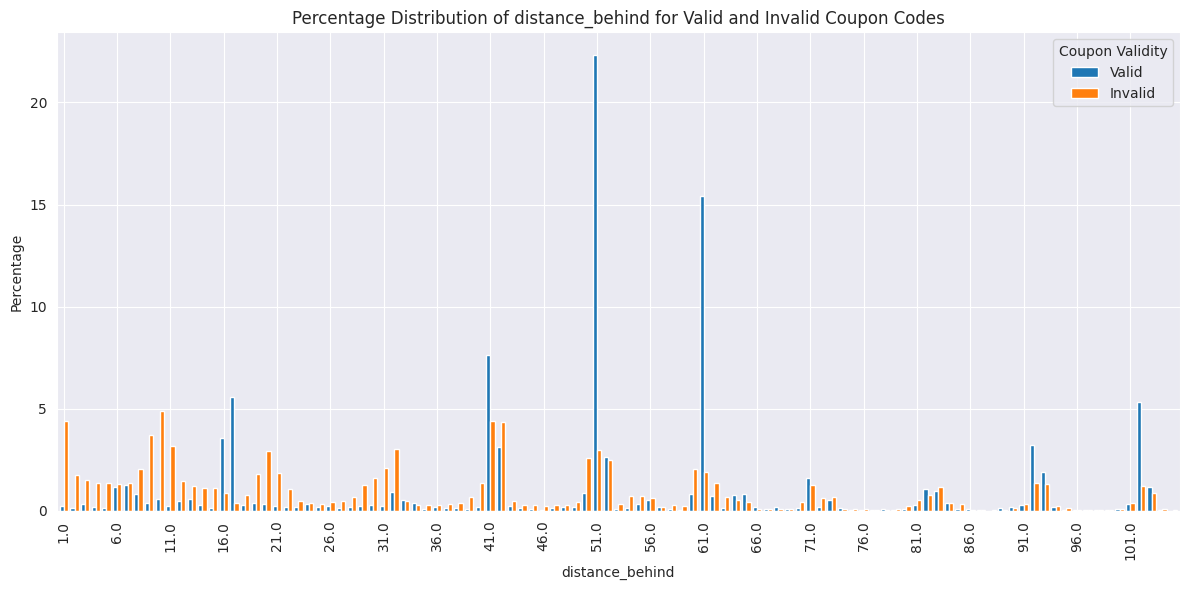

In [135]:
# Count occurrences for valid and invalid coupon codes
valid_counts = df[df['valid'] == True]['distance_behind'].value_counts().sort_index()
invalid_counts = df[df['valid'] == False]['distance_behind'].value_counts().sort_index()

# Convert counts to percentages
valid_percentages = (valid_counts / valid_counts.sum()) * 100
invalid_percentages = (invalid_counts / invalid_counts.sum()) * 100

# Combine the percentages into a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Valid': valid_percentages,
    'Invalid': invalid_percentages
}).fillna(0)  # Fill missing values with 0

# Plot the bar chart for valid and invalid percentages on the same plot
plt.figure(figsize=(12, 6))
ax = comparison_df.plot(kind='bar', stacked=False, figsize=(12, 6), width=0.8)

# Use ax.set() to set title, xlabel, ylabel, and xticks
ax.set(title='Percentage Distribution of distance_behind for Valid and Invalid Coupon Codes',
       xlabel='distance_behind',
       ylabel='Percentage',
       xticks=ax.get_xticks()[::5])
ax.legend(title='Coupon Validity', loc='upper right')
plt.tight_layout()
plt.show()

1. Several digits (16, 17, 41, 42, 51, 52, 61) make up the majority of valid codes.
2. The high count of later digits (e.g., 92, 102) likely comes from cases where a valid code existed at 51, but was used, so the next code was 41 or 51 digits away from the used one.
3. Invalid codes are skewed toward lower numbers (1-10) due to sequential coupon searches.
4. Invalid codes also cluster around common valid distances, as I prioritize testing those.
5. There’s a noticeable imbalance between valid and invalid coupons, which is why I changed the chart to %, but the dataset imbalance still needs addressing.


#### **Correlation Matrix**
I want to see how my numeric features correlate to my target `valid`

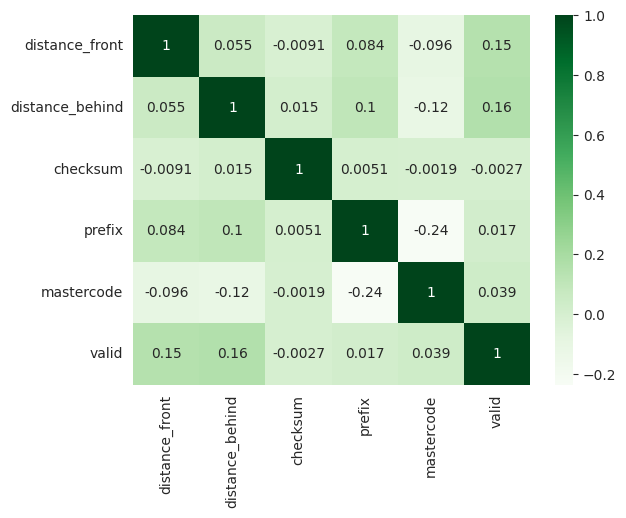

In [136]:
corr_matrix = df[['distance_front', 'distance_behind', 'checksum', 'prefix', 'mastercode', 'valid']].corr()
sns.heatmap(corr_matrix, cmap="Greens", annot=True)
plt.show()

- `distance_front` weak positive correlation - as distance_front increases there's small increase in chance that the coupon is valid
- `distance_behind` weak positive correlation - when a coupon is further away from the previous valid it's slightly more likely to be valid
- `checksum` shows no correlation to valid
- `prefix` shows almost no correlation to valid
- `mastercode` shows almost no correlation to valid

**I'm going to drop checksum and distance_front, because in a real world scenario I wont have access to distance_front, and checksum seems to not correlate to valid**

**I suspect mastercode and prefix wont be helpful either, but I'm keeping them for now**

In [137]:
df = df.drop(['distance_front', 'checksum'], axis=1)

#### **Random Forest Classifier with RFE**
Trying a wrapper method of feature elimination

In [138]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

# Binary encoding over one hot encoding because of how many categories I have
encoder = ce.BinaryEncoder(cols=['prefix', 'mastercode'], drop_invariant=True)
df_encoded = encoder.fit_transform(df)

# remove the original columns after encoding them
df = pd.concat([df.drop(columns=['prefix', 'mastercode']), df_encoded], axis=1)

X = df_encoded.drop(columns=['valid'])
y = df_encoded['valid']

# Initialize the RandomForest model and RFE
model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=5)

rfe.fit(X, y)

rfe_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')

rfe_ranking_sorted = rfe_ranking.sort_values(by='Ranking')

print(rfe_ranking_sorted.head(10))

            Feature  Ranking
9      mastercode_1        1
10     mastercode_2        1
11     mastercode_3        1
12     mastercode_4        1
14  distance_behind        1
13     mastercode_5        2
8      mastercode_0        3
7          prefix_7        4
3          prefix_3        5
6          prefix_6        6


#### **RFE Results**: the RFE shows several parts of the mastercode being an important feature as well as distance_behind, but including the mastercode in my later predictions decreased my model scores considerably.
---

# **Model Selection**
#### **Logistic Regression Classifier:**
- After identifying `distance_behind` as the most relevant feature, I began with 2 simple models, decision tree and logistic regression. The decision tree outperformed logistic regression, so I chose to proceed with the random forest of decision trees.
#### **Decision Tree**
- I tried this model because my original function to generate new codes resembled a decision tree
#### **Random Forest Classifier**
- I chose this model in the end to reduce the chance of overfitting

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df[['distance_behind', 'mastercode']]
y = df['valid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96    120340
        True       0.61      0.16      0.26     11158

    accuracy                           0.92    131498
   macro avg       0.77      0.58      0.61    131498
weighted avg       0.90      0.92      0.90    131498



1. **Performance on `False` (Invalid) Class**: The model performs very well, with high precision correctly identifying nearly all invalid coupons.
2. **Performance on `True` (Valid) Class**: The model has a decent precision but very low recall which results in many false negatives.
3. **Precision-Recall Trade-off**: precision for `True` is decent, the low recall indicates the model is missing a significant number of valid coupons.

#### **Dataset Rebalancing:** try adjusting class_weight

In [97]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.82      0.90     95434
        True       0.28      0.82      0.42      8153

    accuracy                           0.82    103587
   macro avg       0.63      0.82      0.66    103587
weighted avg       0.93      0.82      0.86    103587



1. **Performance on `False` (Invalid) Class**: The model performs well, with high precision and recall, meaning it correctly identifies a lot invalid coupons.
2. **Performance on `True` (Valid) Class**: The model struggles with low precision which gives us a high false positive rate, but with a high recall we can successfully identify a lot valid coupons.
3. **Precision-Recall Trade-off**: Strong recall for both classes, but precision for `True` is low, leading to many false positives.

#### **Dataset Rebalancing:** try undersampling the majority


In [96]:
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

undersampler = RandomUnderSampler(sampling_strategy=0.8)  # Undersample majority class
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

undersampled_model = RandomForestClassifier()
undersampled_model.fit(X_train_resampled, y_train_resampled)

y_pred = undersampled_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.81      0.89     95434
        True       0.27      0.83      0.41      8153

    accuracy                           0.81    103587
   macro avg       0.63      0.82      0.65    103587
weighted avg       0.93      0.81      0.85    103587



#### **Dataset Rebalancing:** try oversampling the minority using SMOTE

In [99]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.8)
X_resampled, y_resampled = smote.fit_resample(X, y)

oversample_X_train, oversample_X_test, oversample_y_train, oversample_y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

oversampled_model = RandomForestClassifier()
oversampled_model.fit(oversample_X_train, oversample_y_train)

oversample_y_pred = oversampled_model.predict(X_test)

print(classification_report(y_test, oversample_y_pred))

              precision    recall  f1-score   support

       False       0.99      0.82      0.90     95434
        True       0.29      0.88      0.44      8153

    accuracy                           0.83    103587
   macro avg       0.64      0.85      0.67    103587
weighted avg       0.93      0.83      0.86    103587



#### **Resampling results**
1. class_weight='balanced' dramatically decreased precision and increased recall, not very balanced
2. Undersampling decreased precision and improved recall to varying degrees across multiple sampling strategies, still not very balanced
3. Oversampling (SMOTE) had very similar results to class_weight='balanced'
4. @TODO combination of under sampling and SMOTE oversampling would better represent our valid class, while retaining more data than under sampling alone.

** move forward with SMOTE sampling as I'm prioritizing more balance between precision and recall.
---

#### **Threshold Tuning**


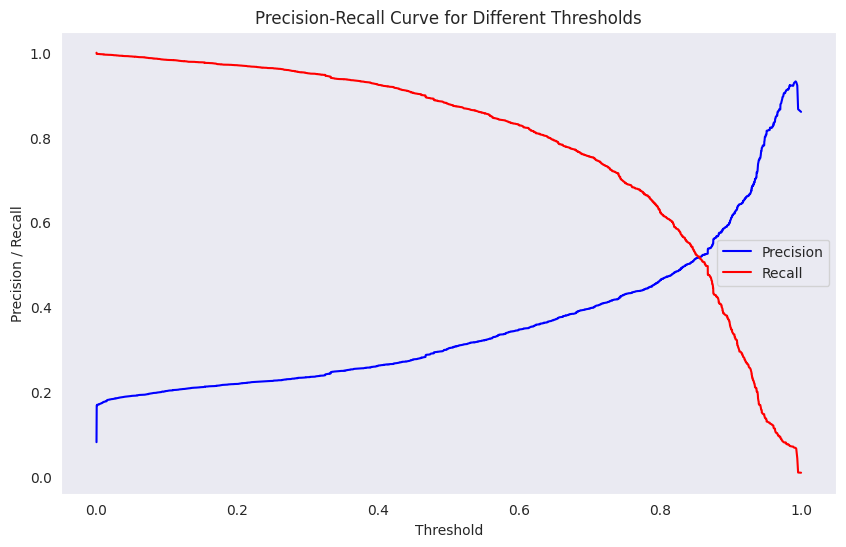

Classification report at threshold 0.6:
              precision    recall  f1-score   support

       False       0.98      0.86      0.92     95205
        True       0.35      0.83      0.49      8382

    accuracy                           0.86    103587
   macro avg       0.66      0.85      0.70    103587
weighted avg       0.93      0.86      0.88    103587



In [106]:
from sklearn.metrics import precision_recall_curve

# Step 1: Get predicted probabilities for the positive class (True)
y_pred_proba = oversampled_model.predict_proba(X_test)[:, 1]

# Step 2: Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Step 3: Plot the precision-recall curve against the thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall Curve for Different Thresholds")
plt.legend(loc="best")
plt.grid()
plt.show()

# Step 4: Choose a threshold based on the plot (example threshold = 0.6)
chosen_threshold = 0.6

# Step 5: Adjust predictions based on the new threshold
y_pred_adjusted = (y_pred_proba >= chosen_threshold).astype(int)

# Step 6: Evaluate the model using the new threshold
print(f"Classification report at threshold {chosen_threshold}:")
print(classification_report(y_test, y_pred_adjusted))

# **Evaluate our Random Forest Classifier with undersampled dataset**


#### **Confusion Matrix**

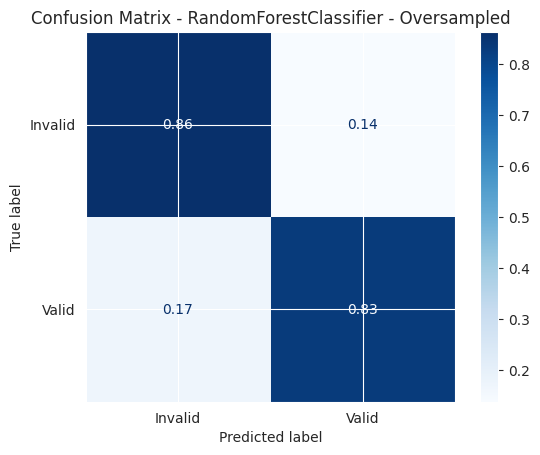

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_adjusted)
# Normalize the confusion matrix by row (i.e., by the actual class counts)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Invalid', 'Valid'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - RandomForestClassifier - Oversampled')
plt.show()

- **True Negative (TN)**: The model correctly predicted **86%** of codes as invalid.
- **False Positive (FP)**: The model incorrectly predicted **~14%** codes as valid (predicted valid, actually invalid).
- **False Negative (FN)**: The model incorrectly predicted **~17%** codes as invalid (predicted invalid, actually valid).
- **True Positive (TP)**: The model correctly predicted **83%** of codes as valid.

#### **ROC-AUC**
let's measure how well the model distinguishes between valid and invalid at various threshholds

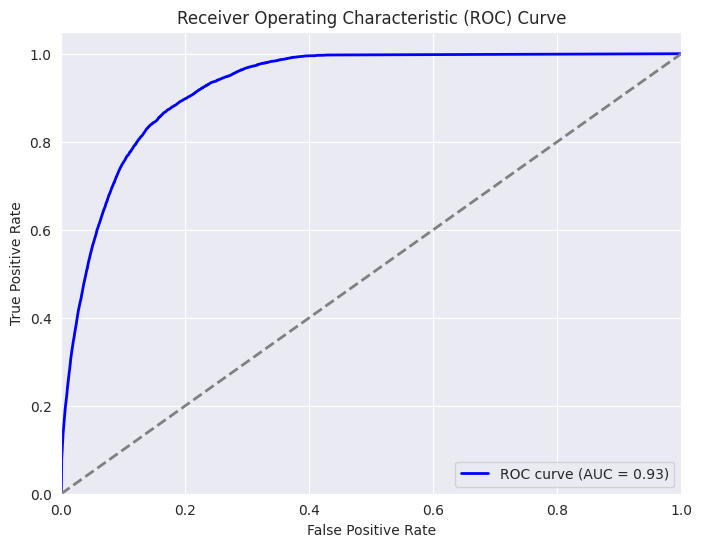

In [113]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = oversampled_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### **ROC-AUC with Undersample Results**
A ROC AUC score or 0.93 indicates the model is performing well at distinguishing between valid and invalid coupon classes. Overall, the model has a good balance between sensitivity and specificity, and it would generalize well to new data.

#### **Cross-Validation**

In [114]:
from sklearn.model_selection import cross_val_score
import numpy as np
scores = cross_val_score(oversampled_model, X_resampled, y_resampled, cv=5, scoring='accuracy')  # precision, recall, f1, roc_auc

mean_cv_score = np.mean(scores)
std_cv_score = np.std(scores)

print("Cross-Validation Accuracy Scores:", scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")
print(f"Standard Deviation of Accuracy (Variance Indicator): {std_cv_score}")


Cross-Validation Accuracy Scores: [0.86763886 0.86627438 0.86546006 0.86649654 0.86469909]
Mean Cross-Validation Accuracy: 0.8661137853904703
Standard Deviation of Accuracy (Variance Indicator): 0.0009926596128599348


#### **Cross-Validation Results**:
- **Accuracy across folds**: very consistent and stable and does not fluctuate significantly on different subsets of data
- **Mean Accuracy**: The model, on average across all folds, is correctly predicting about 86% of the outcomes
- **Low Variance**: The difference between the lowest accuracy and highest accuracy of all folds is very small
- **Low Bias**: The high accuracy indicates tha the model is accurately capturing patterns in the data
---



# **Further Tuning**
Start with a grid search to test our working model with different parameters to find which ones perform best

In [121]:
from sklearn.model_selection import GridSearchCV
import multiprocessing

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()
n_jobs = max(multiprocessing.cpu_count() - 2, 1)  # I crashed using all my cores. Save some for later.

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=n_jobs) # precision, recall, f1, roc_auc
# A different scoring method could be better with an unbalanced dataset, but since I've tried to balance it I'm sticking with accuracy.
grid_search.fit(oversample_X_train, oversample_y_train) # 1.5hours long dont run again

**Best Parameters**:
- `class_weight`: None
- `max_depth`: 20
- `max_features`: 'sqrt'
- `min_samples_leaf`: 2
- `min_samples_split`: 1
- `n_estimators`: 200
- `boostrap`: True


### Cross-Validate
Perform cross validation to ensure our tuned hyperparameters generalize well to unseen data by splitting the data and train+test the model on several subsets of data

In [139]:
from sklearn.model_selection import cross_val_score

rf_tuned = RandomForestClassifier(
    n_estimators=200,        # Number of trees in the forest. A higher number of estimators can lead to better performance but increases training time.
    max_depth=20,            # The maximum depth of the tree. Limits the number of nodes in the tree. Deeper trees can model more complex patterns but may lead to overfitting.
    min_samples_split=2,     # The minimum number of samples required to split an internal node. Lower values allow the model to be more sensitive to small patterns, but may increase overfitting.
    min_samples_leaf=1,      # The minimum number of samples required to be at a leaf node. Setting this to a higher number helps prevent overfitting on very small samples.
    max_features='sqrt',     # The number of features to consider when looking for the best split. 'sqrt' means the square root of the total number of features is considered.
    bootstrap=True,         # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to grow each tree.
    class_weight=None,       # Weights associated with classes. None means that all classes are treated equally. Useful for handling imbalanced datasets by assigning higher weights to the minority class.
)

cv_scores = cross_val_score(rf_tuned, X_resampled, y_resampled, cv=5, scoring='accuracy',n_jobs=n_jobs)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print("Cross-Validation Accuracy Scores:", cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")
print(f"Standard Deviation of Accuracy (Variance Indicator): {std_cv_score}")

Cross-Validation Accuracy Scores: [0.88055357, 0.87938835, 0.8783554, 0.87965379, 0.87762963]
Mean Cross-Validation Accuracy: 0.8791161456567111
Standard Deviation of Accuracy (Variance Indicator): 0.0010215490571096693


Slight improvement in scores, but my adjustments weren't far off from default. Running longer tests with more param combinations might result in better params.

---

# **Conclusion:**

The model demonstrates strong performance with a good balance between precision and recall for both valid and invalid coupons. There is no significant class imbalance, and the metrics are consistently high.

This model helps prioritize newly generated, untested coupons based on their likelihood of validity, ensuring the most likely ones are tested first. Implementing this approach eliminated the need for proxies and resolved early-month inventory issues.

---
